<a href="https://colab.research.google.com/github/peterbabulik/QantumEnhancedGenerativeNeuralArchitecture/blob/main/QantumEnhancedGenerativeNeuralArchitecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install cirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [4]:
import cirq
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

class QuantumGenerativeLayer(tf.keras.layers.Layer):
    """Custom TensorFlow layer for quantum processing"""
    def __init__(self, n_qubits: int, n_layers: int):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.qubits = cirq.LineQubit.range(n_qubits)
        self.n_params_per_qubit = 3  # rx, ry, rz
        self.total_params = n_qubits * n_layers * self.n_params_per_qubit
        self.simulator = cirq.Simulator()

    def build(self, input_shape):
        """Build trainable parameters"""
        self.kernel = self.add_weight(
            name='quantum_kernel',
            shape=(self.total_params,),
            initializer=tf.keras.initializers.RandomUniform(
                minval=-0.1, maxval=0.1),
            trainable=True
        )

        # Dense layer to process quantum features
        self.dense = tf.keras.layers.Dense(
            input_shape[-1],  # Match input dimension
            activation='tanh'
        )

    def create_circuit(self, parameters):
        """Create quantum circuit with given parameters"""
        circuit = cirq.Circuit()
        param_index = 0

        # Initial superposition
        circuit.append(cirq.H.on_each(self.qubits))

        for layer in range(self.n_layers):
            # Rotation gates
            for i, qubit in enumerate(self.qubits):
                rx_param = float(parameters[param_index])
                ry_param = float(parameters[param_index + 1])
                rz_param = float(parameters[param_index + 2])

                circuit.append([
                    cirq.rx(rx_param)(qubit),
                    cirq.ry(ry_param)(qubit),
                    cirq.rz(rz_param)(qubit)
                ])
                param_index += 3

            # Entangling layer
            for i in range(self.n_qubits - 1):
                circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i + 1]))

        return circuit

    def get_quantum_features(self, parameters):
        """Simulate quantum circuit and get features"""
        try:
            # Convert parameters to numpy array
            params_np = np.array(parameters)

            # Create and simulate circuit
            circuit = self.create_circuit(params_np)
            result = self.simulator.simulate(circuit)
            state_vector = result.final_state_vector

            # Convert to real-valued features
            features = np.concatenate([
                np.real(state_vector),
                np.imag(state_vector)
            ])

            return features.astype(np.float32)

        except Exception as e:
            print(f"Error in quantum simulation: {str(e)}")
            # Return zeros if simulation fails
            return np.zeros(2 * 2**self.n_qubits, dtype=np.float32)

    def call(self, inputs):
        """Forward pass"""
        batch_size = tf.shape(inputs)[0]

        # Get quantum features using numpy function
        quantum_features = tf.py_function(
            func=self.get_quantum_features,
            inp=[self.kernel],
            Tout=tf.float32
        )

        # Reshape quantum features
        quantum_features = tf.reshape(quantum_features, [1, -1])

        # Tile for batch processing
        quantum_features = tf.tile(quantum_features, [batch_size, 1])

        # Process quantum features
        processed_features = self.dense(quantum_features)

        # Combine with input
        return inputs + processed_features  # Residual connection

class QuantumGenerativeAI(tf.keras.Model):
    """Quantum-enhanced generative autoencoder"""
    def __init__(self, input_dim: int, latent_dim: int, n_qubits: int):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_qubits = n_qubits

        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(latent_dim, activation='tanh'),
            tf.keras.layers.BatchNormalization()
        ], name='encoder')

        # Quantum layer
        self.quantum_layer = QuantumGenerativeLayer(
            n_qubits=n_qubits,
            n_layers=2
        )

        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(input_dim, activation='sigmoid')
        ], name='decoder')

    def call(self, x):
        """Forward pass"""
        # Encode
        z = self.encoder(x)

        # Apply quantum transformation
        z_quantum = self.quantum_layer(z)

        # Decode
        return self.decoder(z_quantum)

    def generate(self, n_samples: int):
        """Generate new samples"""
        z = tf.random.normal((n_samples, self.latent_dim))
        z_quantum = self.quantum_layer(z)
        return self.decoder(z_quantum)

# Test the implementation
print("=== Quantum Enhanced Generative AI ===")

# Model parameters
input_dim = 784  # For MNIST images
latent_dim = 32
n_qubits = 4  # Reduced number of qubits for testing

# Initialize model
model = QuantumGenerativeAI(input_dim, latent_dim, n_qubits)

print("\n1. Model Architecture:")
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"Number of qubits: {n_qubits}")

# Create sample input
print("\n2. Testing forward pass...")
sample_input = tf.random.normal((2, input_dim))
try:
    # Test forward pass
    output = model(sample_input)
    print(f"Output shape: {output.shape}")
    print("Forward pass successful!")

    # Test generation
    print("\n3. Testing generation...")
    generated = model.generate(2)
    print(f"Generated samples shape: {generated.shape}")

    # Print quantum layer info
    print("\n4. Quantum Layer Information:")
    print(f"Number of quantum parameters: {model.quantum_layer.total_params}")
    print(f"Quantum feature dimension: {2 * 2**n_qubits}")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nStacktrace:")
    import traceback
    traceback.print_exc()

=== Quantum Enhanced Generative AI ===

1. Model Architecture:
Input dimension: 784
Latent dimension: 32
Number of qubits: 4

2. Testing forward pass...
Output shape: (2, 784)
Forward pass successful!

3. Testing generation...
Generated samples shape: (2, 784)

4. Quantum Layer Information:
Number of quantum parameters: 24
Quantum feature dimension: 32


=== Quantum Generative AI Training ===

1. Starting Training...

Epoch 1/10


Training: 100%|██████████| 1875/1875 [00:52<00:00, 35.77it/s]


Time taken: 57.59s
Train Loss: 0.0572
Test Loss: 0.0545

Epoch 2/10


Training: 100%|██████████| 1875/1875 [00:41<00:00, 44.89it/s]


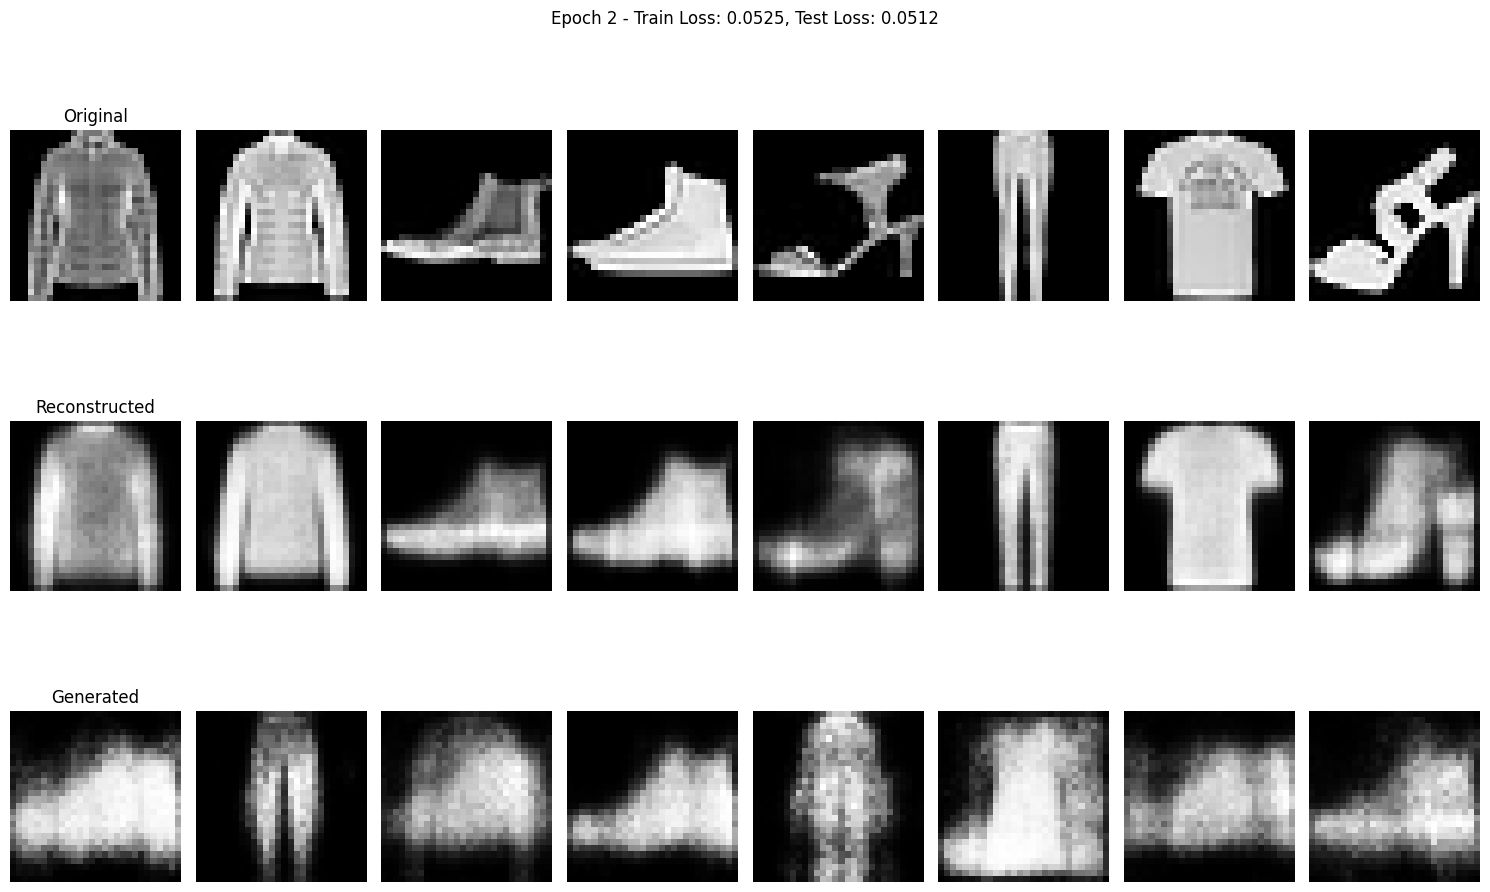

Time taken: 47.94s
Train Loss: 0.0525
Test Loss: 0.0512

Epoch 3/10


Training: 100%|██████████| 1875/1875 [00:43<00:00, 43.33it/s]


Time taken: 46.87s
Train Loss: 0.0499
Test Loss: 0.0493

Epoch 4/10


Training: 100%|██████████| 1875/1875 [00:42<00:00, 44.05it/s]


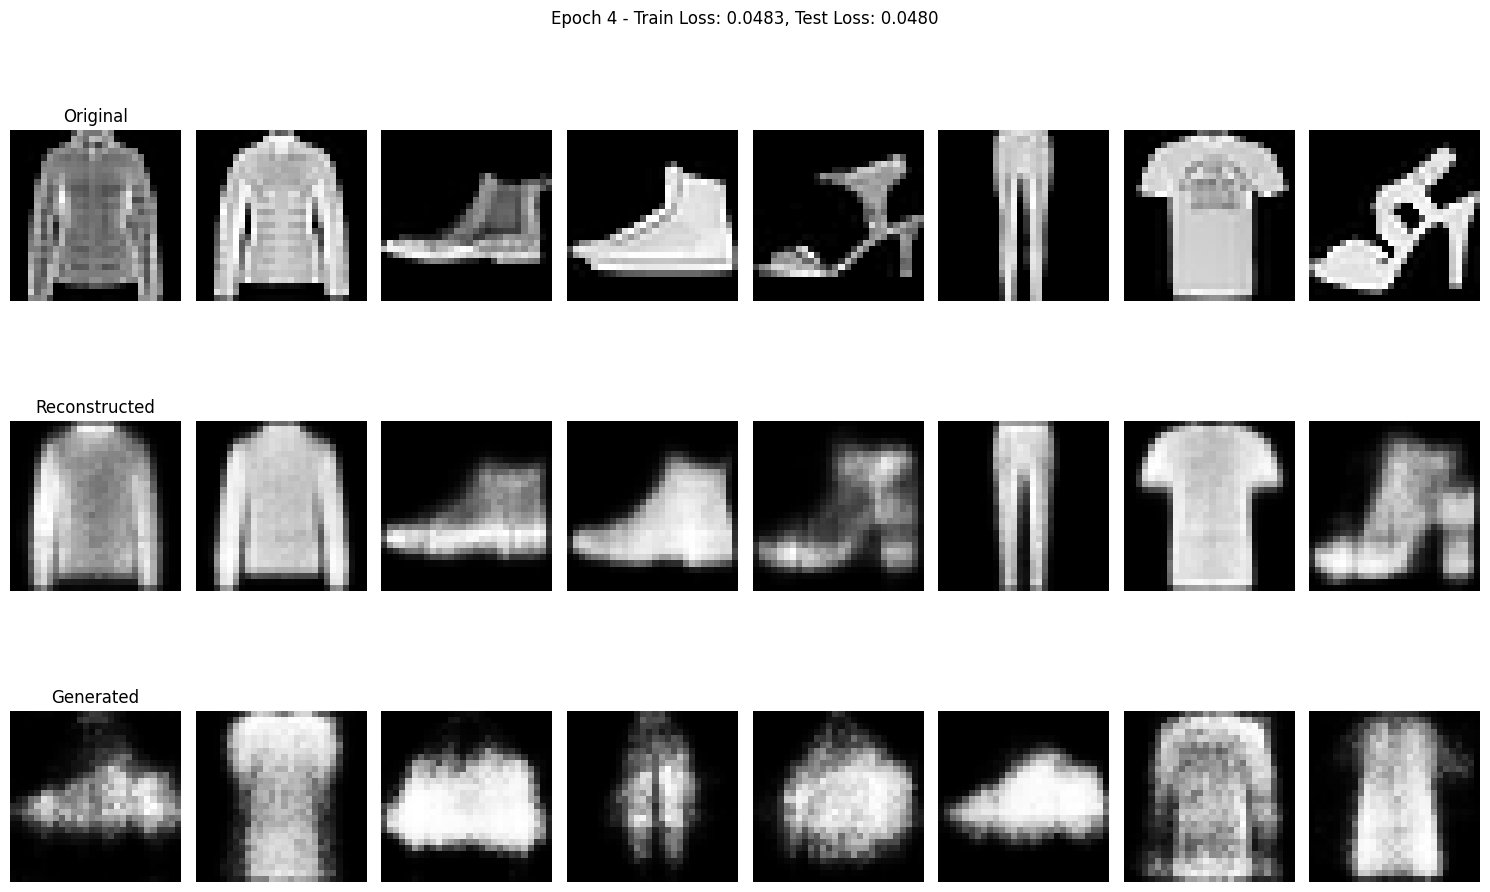

Time taken: 48.42s
Train Loss: 0.0483
Test Loss: 0.0480

Epoch 5/10


Training: 100%|██████████| 1875/1875 [00:42<00:00, 43.71it/s]


Time taken: 46.54s
Train Loss: 0.0472
Test Loss: 0.0469

Epoch 6/10


Training: 100%|██████████| 1875/1875 [00:42<00:00, 44.12it/s]


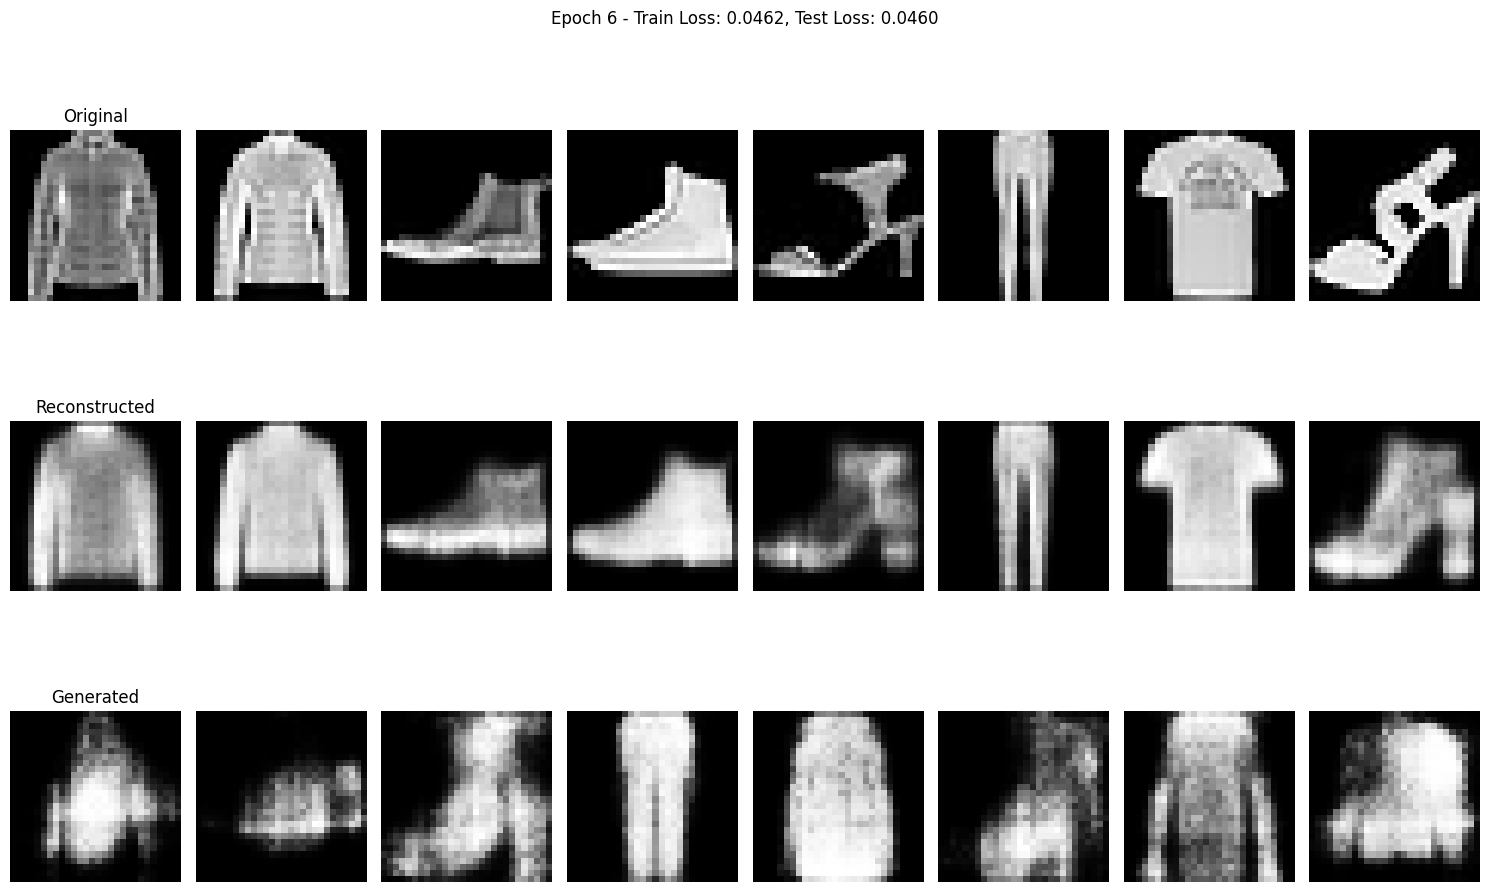

Time taken: 47.92s
Train Loss: 0.0462
Test Loss: 0.0460

Epoch 7/10


Training: 100%|██████████| 1875/1875 [00:44<00:00, 42.55it/s]


Time taken: 49.20s
Train Loss: 0.0454
Test Loss: 0.0453

Epoch 8/10


Training: 100%|██████████| 1875/1875 [00:43<00:00, 43.05it/s]


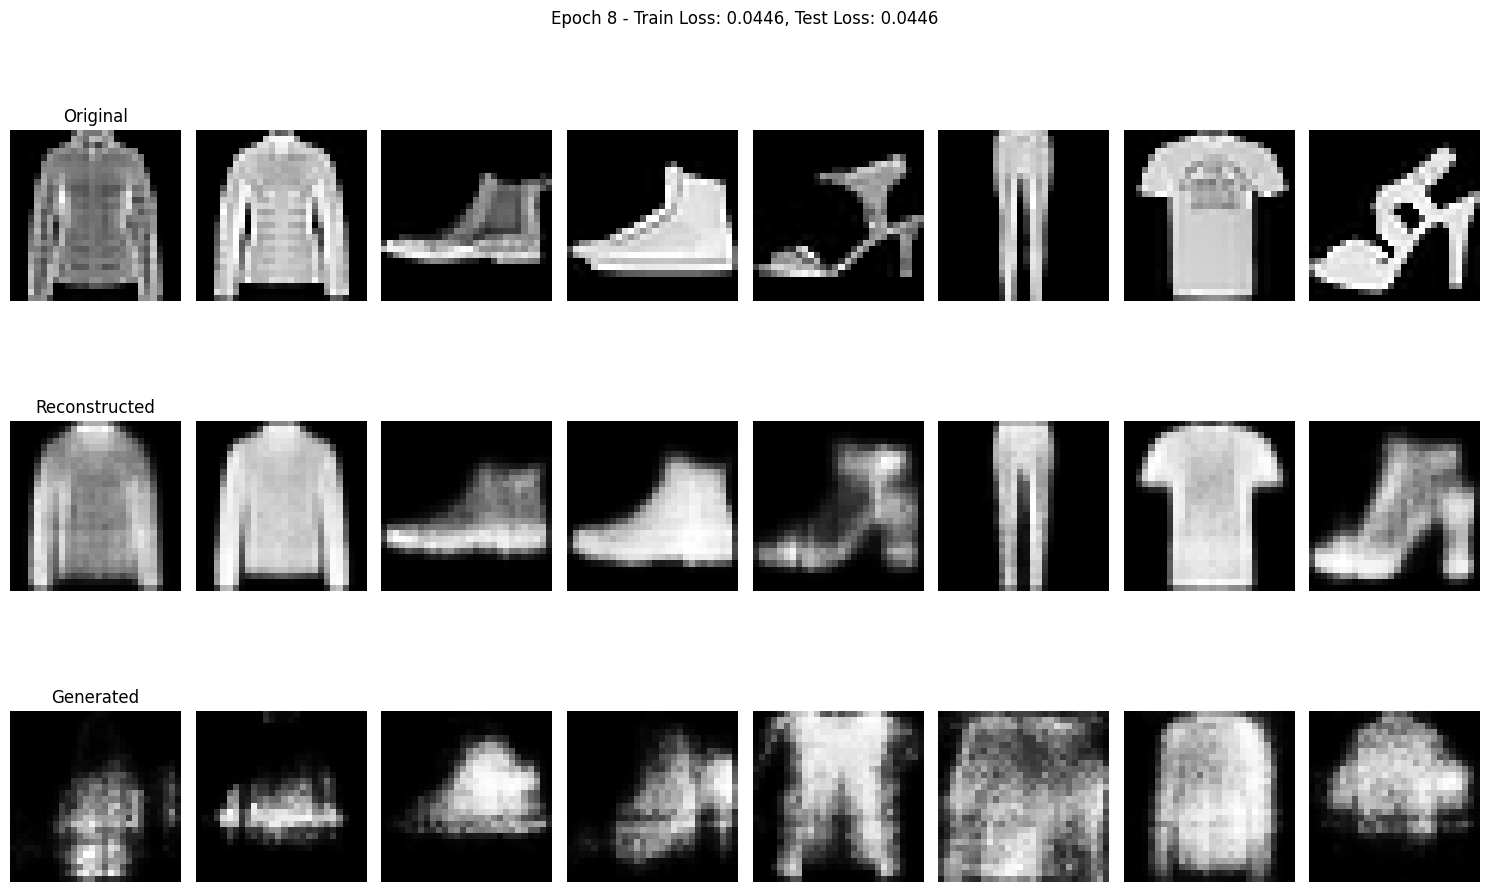

Time taken: 49.75s
Train Loss: 0.0446
Test Loss: 0.0446

Epoch 9/10


Training: 100%|██████████| 1875/1875 [00:44<00:00, 42.49it/s]


Time taken: 47.74s
Train Loss: 0.0440
Test Loss: 0.0441

Epoch 10/10


Training: 100%|██████████| 1875/1875 [00:44<00:00, 42.48it/s]


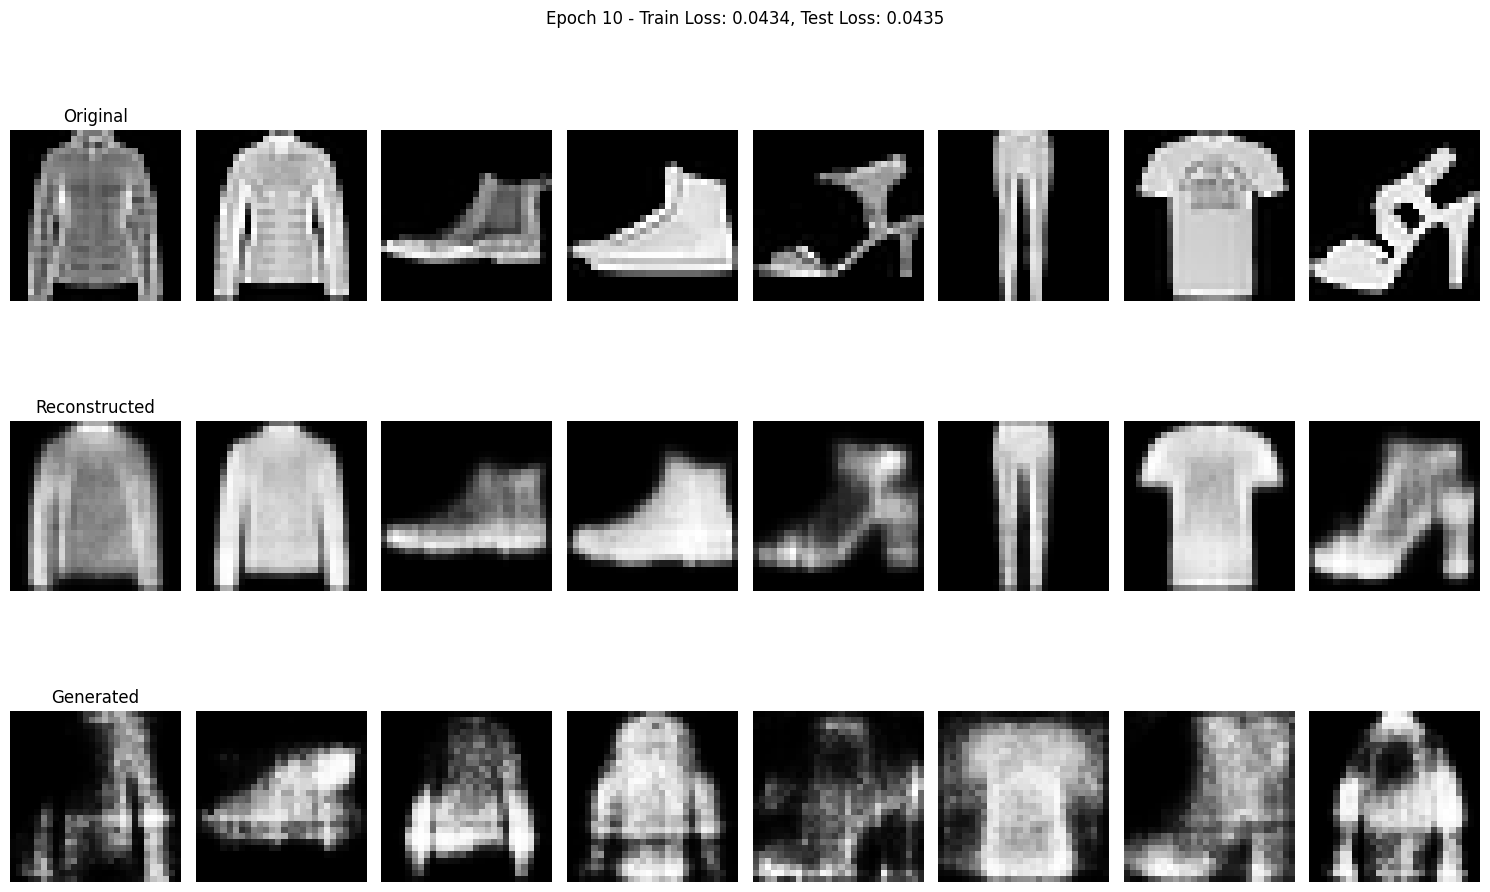

Time taken: 50.17s
Train Loss: 0.0434
Test Loss: 0.0435

2. Final Results:
Final Training Loss: 0.0434
Final Test Loss: 0.0435

3. Generating Final Samples...


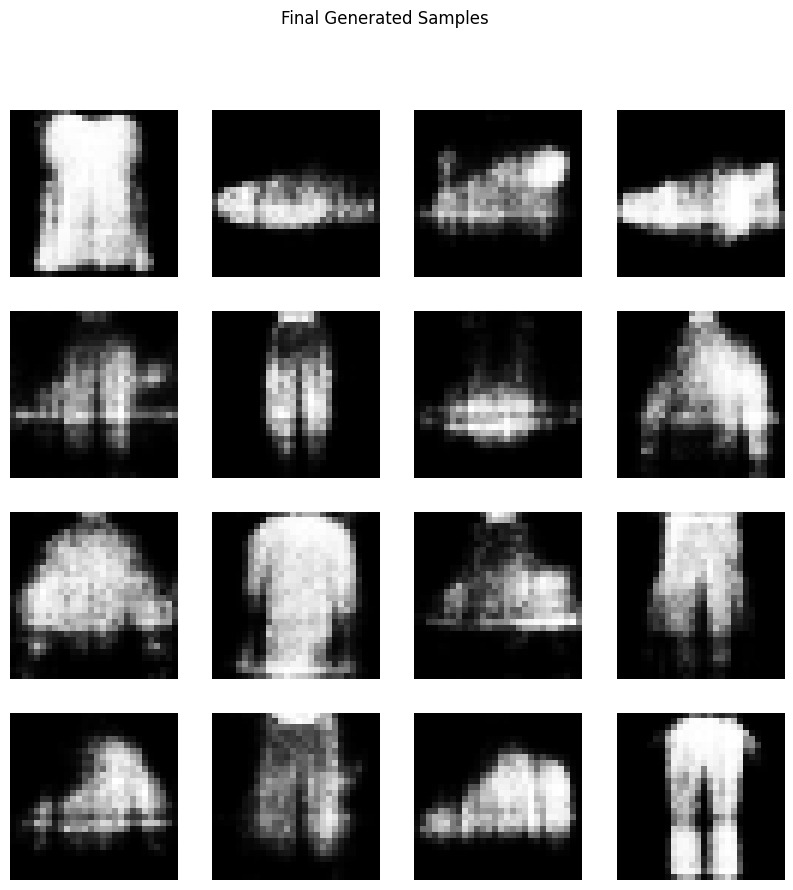

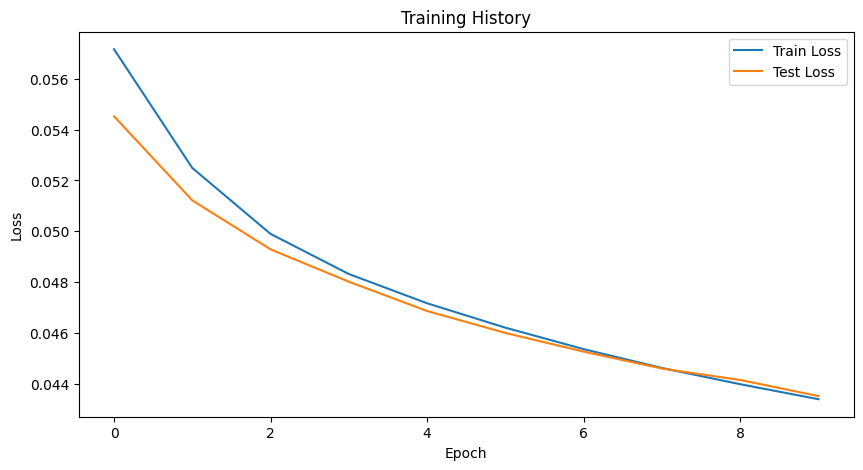

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

class DatasetLoader:
    def __init__(self, dataset_name='fashion_mnist', batch_size=32):
        self.dataset_name = dataset_name
        self.batch_size = batch_size

    def load_and_preprocess(self):
        if self.dataset_name == 'fashion_mnist':
            (train_ds, test_ds), ds_info = tfds.load(
                'fashion_mnist',
                split=['train', 'test'],
                shuffle_files=True,
                as_supervised=True,
                with_info=True,
            )
        else:
            (train_ds, test_ds), ds_info = tfds.load(
                'mnist',
                split=['train', 'test'],
                shuffle_files=True,
                as_supervised=True,
                with_info=True,
            )

        def preprocess(image, label):
            image = tf.cast(image, tf.float32)
            image = image / 255.0
            image = tf.reshape(image, [784])
            return image

        train_ds = train_ds.map(lambda x, y: preprocess(x, y))
        train_ds = train_ds.shuffle(10000).batch(self.batch_size)

        test_ds = test_ds.map(lambda x, y: preprocess(x, y))
        test_ds = test_ds.batch(self.batch_size)

        return train_ds, test_ds, ds_info

class QuantumGenerativeTrainer:
    def __init__(self, model, dataset_loader, learning_rate=1e-4):
        self.model = model
        self.dataset_loader = dataset_loader
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

        # Initialize metrics as running averages
        self.train_loss_avg = tf.keras.metrics.Mean()
        self.test_loss_avg = tf.keras.metrics.Mean()

    def loss_function(self, original, reconstructed):
        """Combined reconstruction loss"""
        # MSE for overall reconstruction quality
        mse = tf.reduce_mean(tf.square(original - reconstructed))

        # Binary cross-entropy for detail preservation
        epsilon = 1e-7
        reconstructed = tf.clip_by_value(reconstructed, epsilon, 1 - epsilon)
        bce = -tf.reduce_mean(
            original * tf.math.log(reconstructed) +
            (1 - original) * tf.math.log(1 - reconstructed)
        )

        return mse + 0.1 * bce

    @tf.function
    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            reconstructed = self.model(inputs)
            loss = self.loss_function(inputs, reconstructed)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Update training metrics
        self.train_loss_avg.update_state(loss)
        return loss

    @tf.function
    def test_step(self, inputs):
        reconstructed = self.model(inputs)
        loss = self.loss_function(inputs, reconstructed)
        # Update test metrics
        self.test_loss_avg.update_state(loss)
        return loss

    def train(self, epochs=10):
        """Train the model"""
        train_ds, test_ds, ds_info = self.dataset_loader.load_and_preprocess()

        history = {
            'train_loss': [],
            'test_loss': [],
            'reconstructions': [],
            'generations': []
        }

        for epoch in range(epochs):
            start_time = time.time()

            # Reset metrics at start of epoch
            self.train_loss_avg.reset_state()
            self.test_loss_avg.reset_state()

            print(f"\nEpoch {epoch + 1}/{epochs}")

            # Training loop
            for batch in tqdm(train_ds, desc="Training"):
                loss = self.train_step(batch)

            # Testing loop
            for batch in test_ds:
                self.test_step(batch)

            # Get current metrics
            train_loss = self.train_loss_avg.result().numpy()
            test_loss = self.test_loss_avg.result().numpy()

            # Record history
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)

            # Visualization and sample generation
            if (epoch + 1) % 2 == 0:
                sample_batch = next(iter(test_ds))
                reconstructed = self.model(sample_batch[:8])
                generated = self.model.generate(8)

                history['reconstructions'].append(reconstructed)
                history['generations'].append(generated)

                self.visualize_progress(
                    sample_batch[:8],
                    reconstructed,
                    generated,
                    epoch,
                    train_loss,
                    test_loss
                )

            # Print epoch results
            print(f"Time taken: {time.time() - start_time:.2f}s")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Test Loss: {test_loss:.4f}")

        return history

    def visualize_progress(self, original, reconstructed, generated, epoch, train_loss, test_loss):
        """Visualize training progress"""
        plt.figure(figsize=(15, 10))

        # Plot original images
        for i in range(8):
            plt.subplot(3, 8, i + 1)
            plt.imshow(tf.reshape(original[i], [28, 28]), cmap='gray')
            plt.axis('off')
        plt.subplot(3, 8, 1).set_title('Original')

        # Plot reconstructed images
        for i in range(8):
            plt.subplot(3, 8, i + 9)
            plt.imshow(tf.reshape(reconstructed[i], [28, 28]), cmap='gray')
            plt.axis('off')
        plt.subplot(3, 8, 9).set_title('Reconstructed')

        # Plot generated images
        for i in range(8):
            plt.subplot(3, 8, i + 17)
            plt.imshow(tf.reshape(generated[i], [28, 28]), cmap='gray')
            plt.axis('off')
        plt.subplot(3, 8, 17).set_title('Generated')

        plt.suptitle(f'Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        plt.tight_layout()
        plt.show()

# Training setup and execution
print("=== Quantum Generative AI Training ===")

# Initialize components
batch_size = 32
dataset_loader = DatasetLoader(dataset_name='fashion_mnist', batch_size=batch_size)
trainer = QuantumGenerativeTrainer(model, dataset_loader)

print("\n1. Starting Training...")
history = trainer.train(epochs=10)

print("\n2. Final Results:")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Test Loss: {history['test_loss'][-1]:.4f}")

# Generate and visualize final samples
print("\n3. Generating Final Samples...")
final_samples = model.generate(16)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(tf.reshape(final_samples[i], [28, 28]), cmap='gray')
    plt.axis('off')
plt.suptitle('Final Generated Samples')
plt.show()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()